# Detection of modified images or videos using Neural Networks

## Importing the libraries

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageFilter
import pandas as pd
import os
import io
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Lambda, Resizing, GlobalAveragePooling2D
from keras.applications import ResNet50, MobileNet
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools


## Downloading the dataset

In [2]:
URL = "sophatvathana/casia-dataset"
PATH_DATASET = './../dataset/'

def download_dataset():
    api = KaggleApi()
    api.authenticate()
    print("Downloading files...")
    api.dataset_download_files('sophatvathana/casia-dataset', path=PATH_DATASET, unzip=True)

    print("\rDownload complete.")


def clean_directory():
    print("Moving folder...")
    os.rename(PATH_DATASET+"CASIA2/Au", PATH_DATASET+"Au")
    os.rename(PATH_DATASET+"CASIA2/Tp", PATH_DATASET+"Tp")
    
    print("Cleaning directory...")
    shutil.rmtree(PATH_DATASET+"casia")
    shutil.rmtree(PATH_DATASET+"CASIA1")
    shutil.rmtree(PATH_DATASET+"CASIA2")
    os.remove(PATH_DATASET+"Tp/Thumbs.db")
    os.remove(PATH_DATASET+"Au/Thumbs.db")
    print("Cleaning complete.")

In [3]:
if not os.path.exists(PATH_DATASET+"Au"):
    download_dataset()
    clean_directory()
else:
    print("Dataset already Downloaded.")

Dataset already Downloaded.


## Analyzing the dataset

### Creating function to analyze the dataset

In [4]:
REAL_IMAGE_PATH = '../dataset/Au'
FAKE_IMAGE_PATH = "../dataset/Tp"
IMG_SIZE = (256, 256)

def count_files(path: str) -> int:
    return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

#create a category for evry split by _ and add it to the list
def create_tampering_list(path: str, delimeter: int) -> list:
    category_list = []
    for file in os.listdir(path):
        category = file.split("_")
        for i in range(1, len(category)-delimeter):
            if category[i] not in category_list:
                category_list.append(category[i])
    return category_list

#count images in each category
def count_images_in_category(path: str, category: str) -> int:
    count = 0
    for file in os.listdir(path):
        if file.__contains__(category):
            count += 1
    return count

#count images in each category and add it to the dictionary
def create_category_dictionary(path: str) -> dict:
    dicc_categories = {}
    #category_list = create_category_list(path, delimeter)
    category_list = ["ani", "arc", "art", "cha", "nat", "pla", "sec", "txt"]
    for category in category_list:
        dicc_categories[category] = count_images_in_category(path, category)
    return dicc_categories

def create_trampering_dictionary(path: str) -> dict:
    dicc_trampering = {}
    for file in os.listdir(path):
        trampering = file.split("_")
        tram_region = trampering[1]
        tram_key = trampering[5][:3]

        if tram_key not in dicc_trampering:
            dicc_trampering[tram_key] = {tram_region: 1}
        else:
            if tram_region not in dicc_trampering[tram_key]:
                dicc_trampering[tram_key][tram_region] = 1
            else:
                dicc_trampering[tram_key][tram_region] += 1
    return dicc_trampering


#plot the dictionary
def plot_dictionary(dictionary: dict) -> None:
    plt.bar(range(len(dictionary)), list(dictionary.values()), align='center')
    plt.xticks(range(len(dictionary)), list(dictionary.keys()))
    plt.show()

def multiple_bar_plots(dictionary: dict) -> None:
    x = dictionary.keys()
    x_axis = np.arange(len(x))
    d = []
    s = []
    for key in x:
        d.append(dictionary[key]['D'])
        s.append(dictionary[key]['S'])

    plt.bar(x_axis - 0.2, d, 0.4, label='Different')
    plt.bar(x_axis + 0.2, s, 0.4, label='Same')
    
    plt.xticks(x_axis, x)
    plt.xlabel("Category")
    plt.ylabel("Number of images")
    plt.title("Tampering region by category")
    
    plt.legend()
    plt.show()


def show_image_from_category(path: str, dicc_categories: dict) -> None:
    rows = 4
    columns = 2
    fig = plt.figure(figsize=(10, 10))

    for i, category in enumerate(dicc_categories.keys()):
        for file in os.listdir(path):
            if category in file:
                img = Image.open(os.path.join(path, file))
                fig.add_subplot(rows, columns, i+1)
                plt.title(category)
                plt.imshow(img)
                plt.axis('off')
                break
    plt.show()

### Analyzing the real images

Number of real images:  7491
Number of categories:  8


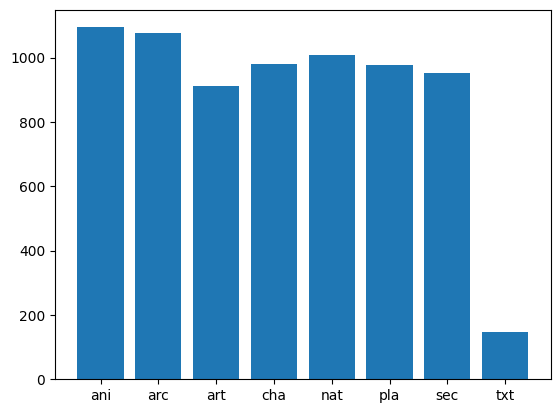

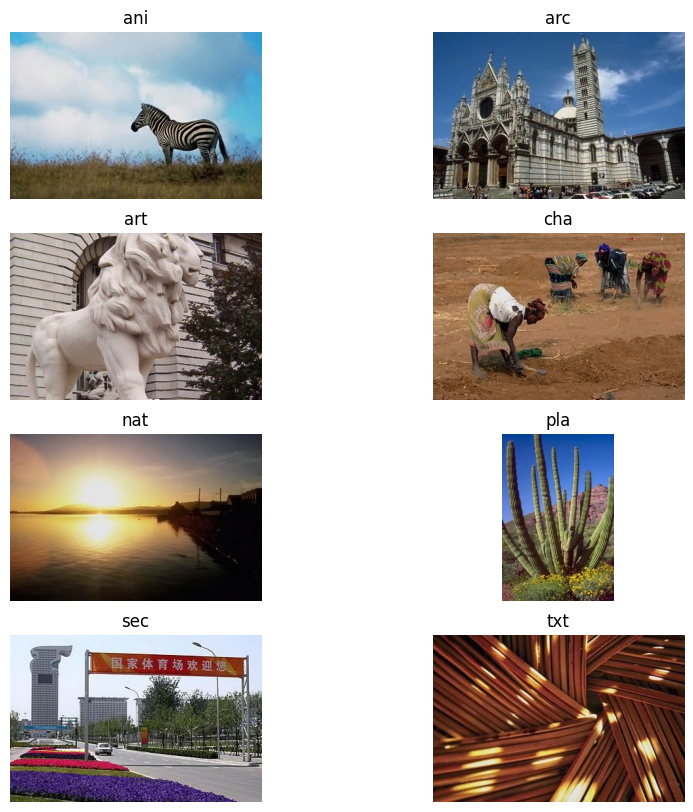

In [5]:
dicc_real = create_category_dictionary(REAL_IMAGE_PATH)

print("Number of real images: ", count_files(REAL_IMAGE_PATH))
print("Number of categories: ", len(dicc_real))
plot_dictionary(dicc_real)

show_image_from_category(REAL_IMAGE_PATH, dicc_real)

### Analyzing the fake images

Number of fake images:  5123
Number of categories:  8


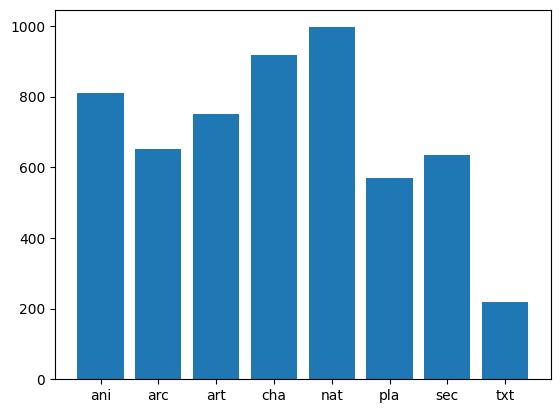

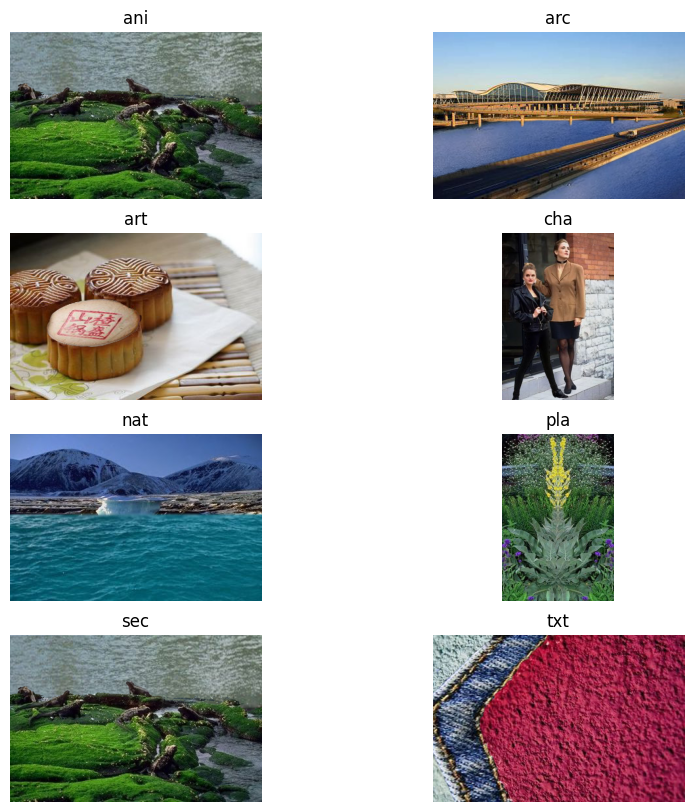

In [6]:
dicc_fake = create_category_dictionary(FAKE_IMAGE_PATH)

print("Number of fake images: ", count_files(FAKE_IMAGE_PATH))
print("Number of categories: ", len(dicc_fake))
plot_dictionary(dicc_fake)

show_image_from_category(FAKE_IMAGE_PATH, dicc_fake)

### Analyzing type of Tampering in the images

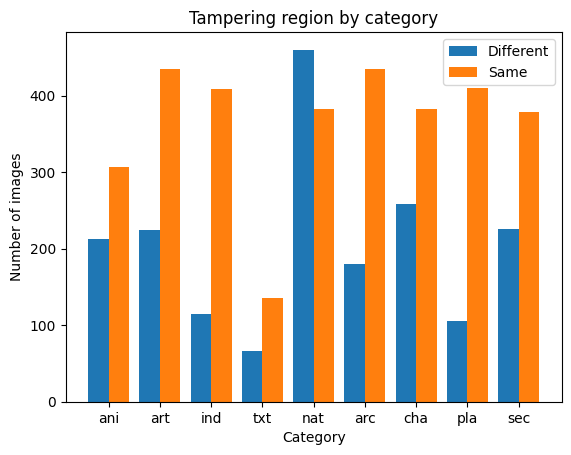

In [7]:
dicc_tp = create_trampering_dictionary(FAKE_IMAGE_PATH)
multiple_bar_plots(dicc_tp)

## Solving problms related to the dataset

Debido a que la categoria textil no es muy amplia lo mejor sera eliminarlo tanto de las imagenes falsas como de las reales

In [8]:
cabezera = "category", "image", "real"
df_au = pd.DataFrame(columns=cabezera)

for idx, file in enumerate(os.listdir(REAL_IMAGE_PATH)):
    img = cv2.imread(os.path.join(REAL_IMAGE_PATH, file))
    img = cv2.resize(img, IMG_SIZE)
    #img_np = np.array(img)
    category = file.split("_")

    df_au = pd.concat([df_au, pd.DataFrame([[category[1], img, 1]], columns=cabezera)], ignore_index=True)

df_au.head()


category                                              image real
0      ani  [[[226, 185, 76], [222, 180, 73], [221, 180, 7...    1
1      ani  [[[159, 133, 119], [156, 131, 120], [149, 123,...    1
2      ani  [[[0, 7, 7], [3, 14, 12], [16, 31, 24], [16, 3...    1
3      ani  [[[40, 19, 21], [39, 21, 22], [39, 21, 22], [4...    1
4      ani  [[[79, 21, 9], [80, 22, 10], [81, 22, 10], [83...    1

In [9]:
#remove categoriy txt because it is not in the dataset
df_au = df_au[df_au.category != "txt"]
df_au = df_au[df_au.category != "ind"]
#mezclar el dataframe
df_au = df_au.sample(frac=1).reset_index(drop=True)

In [10]:
#mezclar el dataframe
df_au = df_au.sample(frac=1).reset_index(drop=True)

In [11]:
df_au.head()

category                                              image real
0      nat  [[[216, 219, 223], [216, 219, 223], [216, 219,...    1
1      pla  [[[124, 80, 51], [125, 79, 49], [127, 80, 49],...    1
2      ani  [[[68, 101, 74], [71, 105, 78], [74, 110, 83],...    1
3      cha  [[[28, 39, 67], [25, 36, 64], [24, 36, 65], [2...    1
4      art  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1

In [12]:
#cogemos 600 imagenes de cada categoria
df_au = df_au.groupby('category').head(600)
#muestra el numero de imagenes por categoria
df_au.groupby('category').size()

category
ani    600
arc    600
art    600
cha    600
nat    600
pla    600
sec    600
dtype: int64

Realizaremos el mismo proceso con las imagenes modificadas

In [13]:
cabezera = "category", "image", "region", "real"
key_list = ["ani", "arc", "art", "cha", "nat", "pla", "sec"]
df_tp = pd.DataFrame(columns=cabezera)

for file in os.listdir(FAKE_IMAGE_PATH):
    #convert image to np array
    img = cv2.imread(os.path.join(FAKE_IMAGE_PATH, file))
    img = cv2.resize(img, IMG_SIZE)
    #img_np = np.array(img)
    category = file.split("_")
    category[5] = category[5][:3]
    df_tp = pd.concat([df_tp, pd.DataFrame([[category[5], img, category[1], 0]], columns=cabezera)], ignore_index=True)

df_tp.head()

category                                              image region real
0      ani  [[[197, 173, 153], [197, 173, 153], [199, 175,...      D    0
1      art  [[[9, 13, 18], [8, 12, 17], [8, 12, 17], [9, 1...      D    0
2      art  [[[189, 181, 181], [173, 169, 169], [137, 139,...      D    0
3      ani  [[[48, 78, 59], [65, 95, 76], [65, 91, 78], [6...      D    0
4      ind  [[[9, 14, 12], [11, 14, 14], [17, 15, 16], [18...      D    0

In [14]:
df_tp = df_tp[df_tp.category != "txt"]
df_tp = df_tp[df_tp.category != "ind"]
df_tp = df_tp.sample(frac=1).reset_index(drop=True)

In [15]:
df_tp.head()

category                                              image region real
0      ani  [[[7, 24, 15], [10, 27, 18], [12, 30, 23], [17...      S    0
1      art  [[[4, 2, 2], [4, 2, 2], [4, 2, 2], [4, 2, 2], ...      S    0
2      arc  [[[149, 117, 106], [150, 118, 107], [151, 119,...      S    0
3      cha  [[[188, 172, 156], [189, 173, 157], [190, 174,...      S    0
4      pla  [[[55, 135, 106], [66, 146, 117], [73, 154, 12...      S    0

In [16]:
#cogemos 600 imagenes de cada categoria pero 300 de cada region
df_tp = df_tp.groupby(['category', 'region']).head(300)
#muestra el numero de imagenes por categoria
df_tp.groupby(['category', 'region']).size()

category  region
ani       D         213
          S         300
arc       D         180
          S         300
art       D         225
          S         300
cha       D         259
          S         300
nat       D         300
          S         300
pla       D         105
          S         300
sec       D         226
          S         300
dtype: int64

## Re-analyzing the dataset

Text(0.5, 1.0, 'Total Real images by category')

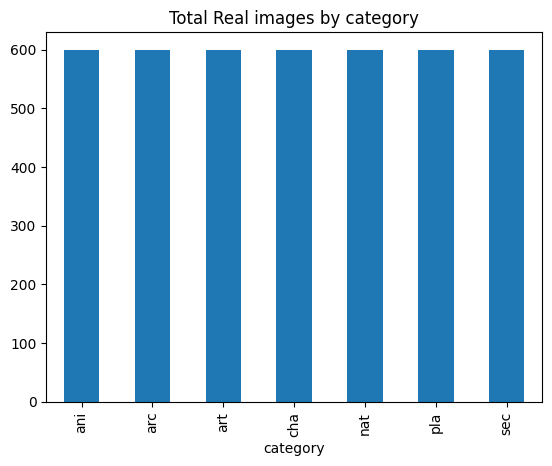

In [17]:
#plot cantidad de imagenes por categoria
#with y label "Quantity of images"
df_au.groupby('category').size().plot(kind='bar').set_title("Total Real images by category")

In [18]:
def multiple_bar_plots_df(dataframe: pd.DataFrame) -> None:
    x = dataframe['category'].unique()
    x_axis = np.arange(len(x))
    d = []
    s = []
    for key in x:
        d.append(dataframe[dataframe['category'] == key]['region'].value_counts()['D'])
        s.append(dataframe[dataframe['category'] == key]['region'].value_counts()['S'])

    plt.bar(x_axis - 0.2, d, 0.4, label='Different')
    plt.bar(x_axis + 0.2, s, 0.4, label='Same')
    
    plt.xticks(x_axis, x)
    plt.xlabel("Category")
    plt.ylabel("Number of images")
    plt.title("Tampering region by category")
    
    plt.legend()
    plt.show()

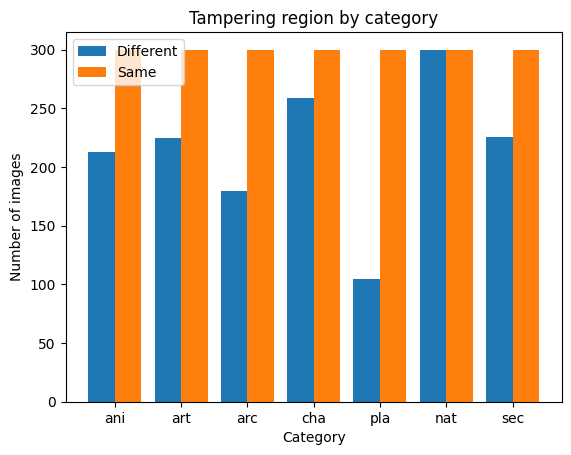

In [19]:
multiple_bar_plots_df(df_tp)

## Error Level Anlaysis on the images

El ELA compara los niveles de compresión de una imagen, es decir, la cantidad de compresión que se ha aplicado a diferentes áreas de la imagen. Las áreas de la imagen que han sido alteradas o manipuladas digitalmente pueden tener niveles de compresión diferentes a las áreas circundantes, lo que puede indicar que ha habido algún tipo de modificación.

Para realizar un análisis de ELA, se toma la imagen original y se la vuelve a guardar con una compresión específica. Luego, se compara la versión original con la versión comprimida utilizando una herramienta de análisis de ELA. Las áreas que tienen una compresión diferente de la imagen original se resaltarán en la imagen analizada.

In [38]:
def plot_ela_images(original, images: list, qualities: list):
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis('off')
    
    for i, image in enumerate(images):
        fig.add_subplot(1, 4, i+2)
        plt.title("Quality: " + str(qualities[i]))
        plt.imshow(image)
        plt.axis('off')
    plt.show()

def ela(orig_img, quality=90):
    _, buffer = cv2.imencode('.jpg', orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    diff = 15 * cv2.absdiff(orig_img, compressed_img)
    return diff

### Original Image

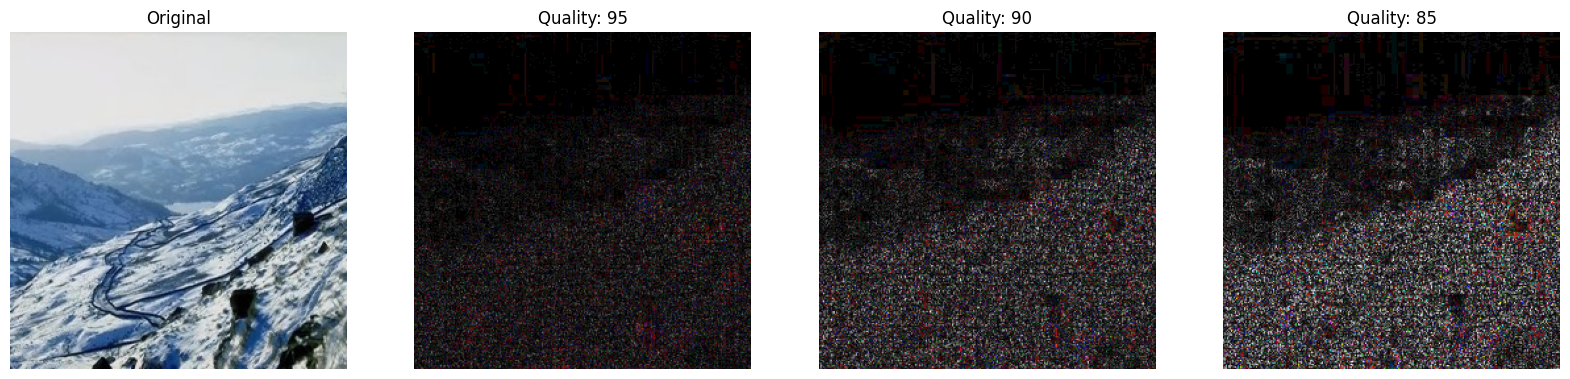

Original image size:  (256, 256, 3)
Compressed image size:  (256, 256, 3)


In [35]:
image = df_au['image'][0]
qualities = [95, 90, 85]
ela_images = [ela(image, quality) for quality in qualities]

plot_ela_images(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), ela_images, qualities)
print("Original image size: ", image.shape)
print("Compressed image size: ", ela_images[0].shape)

### Tempered Image

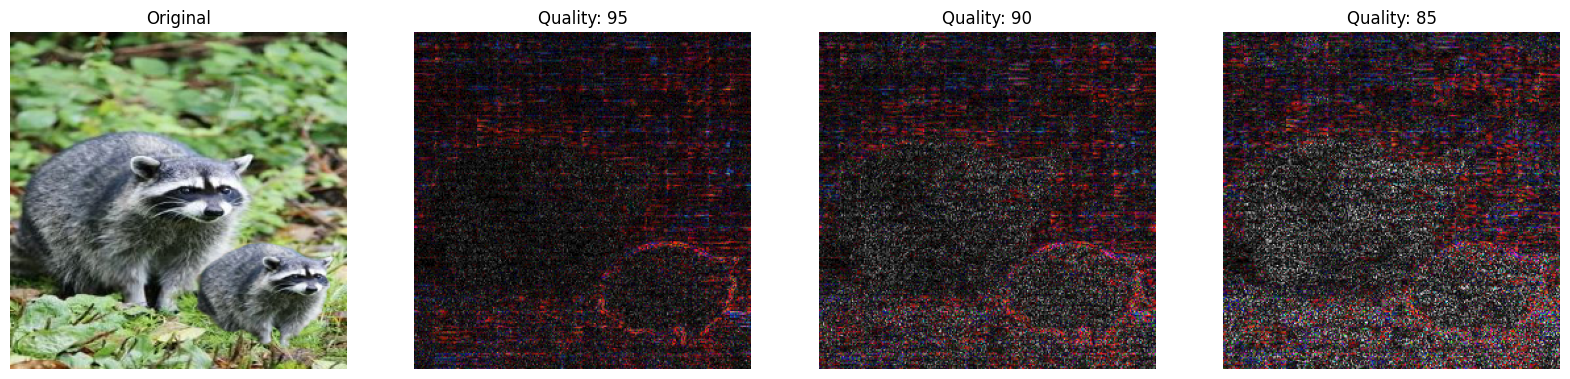

In [36]:
image = df_tp['image'][0]
qualities = [95, 90, 85]

ela_images = [ela(image, quality) for quality in qualities]

plot_ela_images(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), ela_images, qualities)

## Noise Analysis

El análisis de ruido implica la medición de la cantidad de ruido presente en una imagen. Los métodos para medir el ruido varían, pero a menudo implican la comparación de la variabilidad en los valores de los píxeles en diferentes partes de la imagen. Las áreas de una imagen que han sido modificadas por software de edición de imágenes pueden mostrar una cantidad diferente de ruido en comparación con las áreas no modificadas. El análisis de ruido puede ser útil para detectar áreas de una imagen que han sido clonadas, agregadas o borradas.

In [277]:
def noise_analysis(imagen):
    # Convertir la imagen a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Calcular la desviación estándar de los valores de píxeles
    desv_std = np.std(gris)
    
    return desv_std

### Original Image

In [278]:
image = df_au['image'][0]
noise = noise_analysis(image)
print("Noise: " + str(noise))

Noise: 80.66490120078669


### Tempered Image

In [279]:
image = df_tp['image'][0]
noise = noise_analysis(image)
print("Noise: " + str(noise))

Noise: 50.71736026917478


## Shadow and Light Analysis

El análisis de sombras y luces implica la detección de las áreas de una imagen que están en sombra o en luz, y la comparación de estas áreas con las áreas adyacentes. Las áreas de una imagen que han sido modificadas por software de edición de imágenes pueden mostrar diferencias en las sombras y luces en comparación con las áreas no modificadas. El análisis de sombras y luces puede ser útil para detectar áreas de una imagen que han sido clonadas, agregadas o borradas.

In [280]:
def apply_noise_shadow(image):
    # Aplicar análisis de ruido y sombras
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    noise_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 2)
    shadow_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 51, 2)
    return cv2.bitwise_and(cv2.bitwise_not(noise_mask), shadow_mask)

def plot_shadow_images(original, image):
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis('off')
    
    fig.add_subplot(1, 2, 2)
    plt.title("Noise")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Original Image

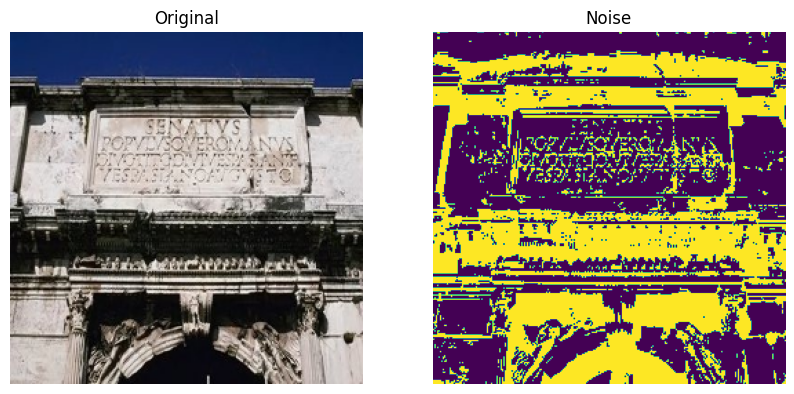

In [281]:
image = df_au['image'][0]
shadow = apply_noise_shadow(image)
plot_shadow_images(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), shadow)

### Tempered Image

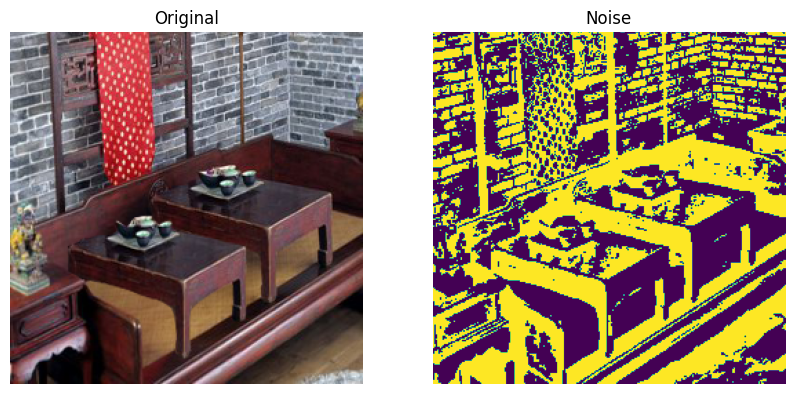

In [282]:
image = df_tp['image'][0]
shadow = apply_noise_shadow(image)
plot_shadow_images(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), shadow)

## Pixel Analysis

El análisis de píxeles implica la medición de los valores de los píxeles en diferentes partes de una imagen. Las áreas de una imagen que han sido modificadas por software de edición de imágenes pueden mostrar diferencias en los valores de los píxeles en comparación con las áreas no modificadas. El análisis de píxeles puede ser útil para detectar áreas de una imagen que han sido clonadas, agregadas o borradas.

In [283]:
def calcular_media_desviacion_estandar(imagen):
    # Convertir la imagen a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Obtener los valores de los píxeles de la imagen
    valores_pixeles = gris.flatten()
    
    # Calcular la media y la desviación estándar de los valores de los píxeles
    media = valores_pixeles.mean()
    desv_std = valores_pixeles.std()
    
    return media, desv_std

### Original Image

In [284]:
image = df_au['image'][0]
mean, std = calcular_media_desviacion_estandar(image)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: 107.26704406738281
Std: 80.66490120078669


### Tempered Image

In [285]:
image = df_tp['image'][0]
mean, std = calcular_media_desviacion_estandar(image)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: 87.48731994628906
Std: 50.71736026917478


## Wavelet Analysis

La técnica de wavelet es una herramienta matemática utilizada para el análisis de señales y procesamiento de imágenes. Cuando se aplica a imágenes, la técnica de wavelet descompone la imagen en diferentes escalas y orientaciones, lo que permite identificar patrones y características de la imagen a diferentes niveles de detalle.

Al aplicar la técnica de wavelet a ambas imágenes (la original y la sospechosa), es posible identificar estas diferencias y, por lo tanto, determinar si la imagen ha sido modificada o no. En particular, se pueden comparar los coeficientes de wavelet de las dos imágenes y analizar las diferencias en función de la escala y la orientación.

## Creating Model

In [39]:
# Preprocesar las imágenes
preprocessed_original = [ela(image) for image in df_au['image']]
preprocessed_manipulated = [ela(image) for image in df_tp['image']]

#CONVERTIMOS LAS IMAGENES A TENSORES

# Convertir las imágenes a tensores de tensorflow
original_tensors = [tf.convert_to_tensor(image) for image in preprocessed_original]
manipulated_tensors = [tf.convert_to_tensor(image) for image in preprocessed_manipulated]


In [40]:
X = np.array(original_tensors + manipulated_tensors)
Y = np.array([0] * len(original_tensors) + [1] * len(manipulated_tensors))

# Dividir el conjunto de datos en entrenamiento validacion y prueba
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

"""x_train = x_train.reshape(x_train.shape[0], 256, 256, 1)
x_val = x_val.reshape(x_val.shape[0], 256, 256, 1)
x_test = x_test.reshape(x_test.shape[0], 256, 256, 1)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)"""

'x_train = x_train.reshape(x_train.shape[0], 256, 256, 1)\nx_val = x_val.reshape(x_val.shape[0], 256, 256, 1)\nx_test = x_test.reshape(x_test.shape[0], 256, 256, 1)\n\ny_train = to_categorical(y_train)\ny_val = to_categorical(y_val)\ny_test = to_categorical(y_test)'

In [49]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=5, 
    verbose=0, 
    mode='auto', 
    baseline=None, 
    restore_best_weights=False
)


model_chekpoint = ModelCheckpoint(
    filepath='model/checkpoints', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch'
)

tensor_board = TensorBoard(
    log_dir='model/logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

callbacks = [early_stopping, model_chekpoint, tensor_board]
optimizer = Adam(learning_rate=0.0001)

In [289]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation=None, input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(5, 5), activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(5, 5), activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [290]:
inputs = Input(shape=(256, 256, 1))
convert_to_rgb = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)
resized_inputs = Resizing(224, 224)(convert_to_rgb)

model = ResNet50(weights='imagenet', include_top=False, input_tensor=resized_inputs)
for layer in model.layers:
    layer.trainable = False

x = Flatten()(model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

In [44]:
inputs = Input(shape=(256, 256, 3))
model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = GlobalAveragePooling2D()(model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=predictions)

In [50]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - 304s 2s/step - loss: 0.0762 - accuracy: 0.9694 - precision: 0.9608 - recall: 0.9737 - auc: 0.9962 - prc: 0.9955 - val_loss: 0.9588 - val_accuracy: 0.7584 - val_precision: 0.6548 - val_recall: 0.9786 - val_auc: 0.9113 - val_prc: 0.8450
Epoch 2/50
157/157 [==============================] - 313s 2s/step - loss: 0.0325 - accuracy: 0.9872 - precision: 0.9866 - recall: 0.9857 - auc: 0.9992 - prc: 0.9992 - val_loss: 0.4576 - val_accuracy: 0.8808 - val_precision: 0.8904 - val_recall: 0.8381 - val_auc: 0.9481 - val_prc: 0.9215
Epoch 3/50
157/157 [==============================] - 327s 2s/step - loss: 0.0254 - accuracy: 0.9908 - precision: 0.9888 - recall: 0.9914 - auc: 0.9992 - prc: 0.9989 - val_loss: 0.5225 - val_accuracy: 0.8904 - val_precision: 0.8670 - val_recall: 0.8932 - val_auc: 0.9435 - val_prc: 0.9004
Epoch 4/50
157/157 [==============================] - 323s 2s/step - loss: 0.0282 - accuracy: 0.9890 - precision: 0.9883 - recall: 0.

In [51]:
model.evaluate(x_test, y_test)

49/49 [==============================] - 21s 420ms/step - loss: 0.7104 - accuracy: 0.8809 - precision: 0.8790 - recall: 0.8646 - auc: 0.9269 - prc: 0.8863


[0.7103817462921143,
 0.8809219002723694,
 0.8789986371994019,
 0.8645690679550171,
 0.9268758893013,
 0.8862730264663696]

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

def plot_loss_accuracy(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Model Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_pred):
    y_pred_binary = np.round(y_pred)
    cm = confusion_matrix(y_test, y_pred_binary)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Original', 'Manipulated'], rotation=45)
    plt.yticks(tick_marks, ['Original', 'Manipulated'])
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(y_pred):
    y_pred = model.predict(x_test)

    # Calcular la curva ROC y el área bajo la curva (AUC)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    auc_score = auc(*precision_recall_curve(y_true, y_pred)[:2])
    return precision, recall, f1_score, auc_score

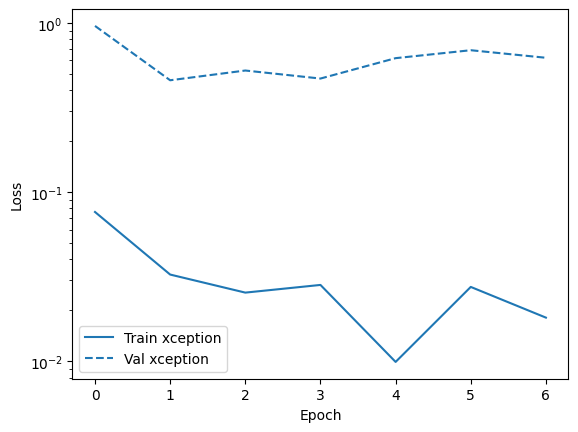

In [53]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(history, 'xception', 0)

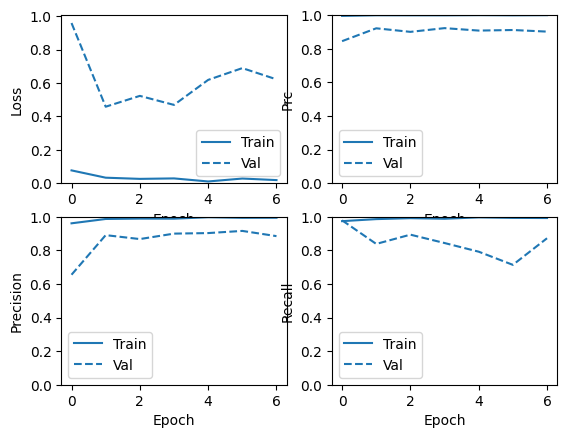

In [54]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], 
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(history)

In [55]:
model.save('./../model/detect_manipulated_images_model_mobileNet.h5')